In [1]:
import numpy as np
import pandas as pd
import os
import calendar
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns =100
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

def readAllCSV():

  month_mapping = {month: index for index, month in enumerate(calendar.month_name) if month}

  file_list = os.listdir('data')

  file_list = sorted(file_list, key=lambda x: month_mapping.get(x.split('.')[0]))
  dfs = []
  for file_name in file_list:

      file_path = os.path.join('data', file_name)
      df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
      dfs.append(df)
  return dfs

def extractUsefulInfo(table, columns):

  df = table[columns]
  df = df.drop(df.index[0])
  #df[columns] = df[columns].astype(float)
  for col in columns:
        df[col] = df[col].astype(float)


  print("Printing NaN's")
  print(df.isna().sum())
  df.dropna(inplace=True)


  return df


def plots(df,column,q_low,q_hi):
  # Set the style of the plot
  sns.set_style("whitegrid")

  # Set the thresholds
  low_threshold = df[column].quantile(q_low)
  high_threshold = df[column].quantile(q_hi)

  # Filter the data
  filtered_data = df[
      (df[column] >= low_threshold) &
      (df[column] <= high_threshold)
  ]

  # Downsampling the data
  max_data_points = 2000  # Maximum number of data points to plot
  if len(filtered_data) > max_data_points:
      indices = np.linspace(0, len(filtered_data) - 1, max_data_points, dtype=int)
      downsampled_data = filtered_data.iloc[indices]
  else:
      downsampled_data = filtered_data

  # Create the plot using Seaborn
  plt.figure(figsize=(10, 6))
  sns.lineplot(x='date', y=column, data=downsampled_data)

  # Set the x-axis tick labels
  num_ticks = 10
  step = len(downsampled_data) // num_ticks
  x_ticks = downsampled_data['date'][::step]
  plt.xticks(x_ticks, rotation=90)

  # Set the plot labels and title
  plt.xlabel('Date')
  plt.ylabel(column)
  plt.title('Visualization of ' + column + ' (Filtered)')

  # Display the plot
  plt.show()


def editDfs(df_list):
    for i in range(len(df_list)):
        df_list[i] = df_list[i].drop(df_list[i].index[0])
        df_list[i]['date1']  = pd.to_datetime(df_list[i]['date'],format='%d/%m/%Y %H:%M' ,errors='coerce')
        df_list[i]['date2'] = pd.to_datetime(df_list[i]['date'], format= '%Y-%m-%d %H:%M:%S.%f', errors='coerce')
        df_list[i]['combined_date'] = df_list[i]['date1'].combine_first(df_list[i]['date2'])
        df_list[i]=df_list[i].drop(['date1'], axis=1)
        df_list[i]=df_list[i].drop(['date2'], axis=1)
        df_list[i]=df_list[i].drop(['date'], axis=1)
        df_list[i]['date'] = df_list[i]['combined_date']
        df_list[i].drop(['combined_date'], axis=1)

    all_months = pd.concat(df_list)
    all_months= all_months.sort_values(by='date')
    all_months= all_months.reset_index(drop=True)
    string_value = 'ERROR'

    all_months = all_months[~all_months.apply(lambda row: string_value in row.values, axis=1)]
    return all_months

def smooth_outliers(data,column,th):
  mean_value = data[column].mean()
  threshold = th * mean_value
  data = data[data[column] >= threshold]
  return data

def PrepareDataset(data,numeric_cols):
    filtered_df = data.groupby('date').mean().reset_index()
    filtered_df['date'] = pd.to_datetime(filtered_df['date'])

    start_date = pd.to_datetime('2019-05-01 00:00:00')
    end_date = pd.to_datetime('2019-11-01 00:00:00')
    interval = pd.Timedelta(seconds=30)

    filtered_df['date'] = pd.to_datetime(filtered_df['date'])
    date_range = pd.date_range(start=start_date, end=end_date, freq=interval)

    missing_dates = date_range[~date_range.isin(filtered_df['date'])]
    missing_df = pd.DataFrame({'date': missing_dates})

    missing_df = missing_df[~missing_df['date'].isin(filtered_df['date'])]
    missing_df = missing_df.merge(filtered_df, on='date', how='outer')
    missing_df = missing_df.sort_values('date').ffill().bfill()

    filtered_df = pd.concat([filtered_df, missing_df])

    filtered_df = filtered_df.groupby('date').mean().reset_index()

    filtered_df = filtered_df.set_index('date')

    preceding_dates = missing_dates - interval
    following_dates = missing_dates + interval

    missing_indices = (preceding_dates.isin(filtered_df.index)) & (following_dates.isin(filtered_df.index))

    preceding_rows = filtered_df.loc[preceding_dates[missing_indices]]
    following_rows = filtered_df.loc[following_dates[missing_indices]]

    mean_values = (preceding_rows.values + following_rows.values) / 2
    mean_values = np.nan_to_num(mean_values, nan=0)

    new_rows = pd.DataFrame(mean_values, columns=filtered_df.columns)
    new_rows.index = missing_dates[missing_indices]

    filtered_df = pd.concat([filtered_df, new_rows])

    filtered_df = filtered_df.sort_index().reset_index()
    filtered_df = filtered_df.rename(columns={filtered_df.columns[0]: 'date'})

    filtered_df = filtered_df.groupby('date').mean().reset_index()

    duplicate_rows = filtered_df.duplicated(subset=filtered_df.columns[1:], keep='last')

    filtered_df = filtered_df[~duplicate_rows]

    filtered_df = filtered_df.drop(filtered_df.index[-1])

    filtered_df= filtered_df.sort_values('date')
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

def Split_Sets(filtered_df, col ,roll, figure):
    train_set = filtered_df[:int(6*len(filtered_df)/10)]
    validation_set = filtered_df[int(6*len(filtered_df)/10):int(8*len(filtered_df)/10)]
    test_set = filtered_df[int(8*len(filtered_df)/10):]


    train_set[col]= train_set[col].rolling(roll).mean()
    validation_set[col]= validation_set[col].rolling(roll).mean()
    test_set[col]= test_set[col].rolling(roll).mean()

    train_set.dropna(inplace=True)
    validation_set.dropna(inplace=True)
    test_set.dropna(inplace=True)

    if figure:
      train_set.set_index('date')[col].plot(label='train')
      validation_set.set_index('date')[col].plot(label='validation')
      test_set.set_index('date')[col].plot(label='test')

      train_set.set_index('date').plot(label='train')
      validation_set.set_index('date').plot(label='validation')
      test_set.set_index('date').plot(label='test')

      plt.legend()

    return train_set, validation_set,test_set

def build_dset(dset,col, lookback, horizon):
    dset = dset[col]
    data = pd.concat([dset.shift(-i) for i in range(lookback+horizon)], axis=1).dropna()

    return data.iloc[:, :lookback], data.iloc[:, lookback:]



def create_Windows(set,columns):
    lookback = 60
    horizon = 10
    X_list = []
    Y_list = []
    tmp = []
    for col in columns:
        x, y = build_dset(set, col, lookback, horizon)
        X_list.append(x)
        Y_list.append(y)

    # remove windows that will have missing dates
    threshold = lookback * pd.Timedelta(seconds=30)
    index_toremove = []
    for index, row in X_list[0].iterrows():
        t1 = row.iloc[0]
        t2 = row.iloc[-1]
        difference = t2 - t1

        if (difference > threshold ):
            index_toremove.append(index)

    mask = ~X_list[0].index.isin(index_toremove)

    for i in range(len(X_list)):
        X_list[i] = X_list[i].loc[mask]
        Y_list[i] = Y_list[i].loc[mask]

    for en in range(0,lookback):
        tmp.append(pd.concat([df.iloc[:, en] for df in X_list[1:]], axis=1))

    x_train = pd.concat(tmp, axis=1)
    x_train.columns = [f'{columns[1:][i%len(columns[1:])]}_column_{i}' for i in range(x_train.shape[1])]

    _, y_train = build_dset(set, columns[-1], lookback, horizon)

    # also remove from y_train the missing dates
    y_train = y_train[mask]
    return x_train,y_train, Y_list[0]

def explore_correlation(df):
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')

    # Create scatter plots
    num_cols = len(df.columns)
    fig, axes = plt.subplots(num_cols, num_cols, figsize=(12, 12))

    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            ax = axes[i][j]
            ax.scatter(df[col1], df[col2])
            ax.set(xlabel=col1, ylabel=col2)

    plt.tight_layout()
    plt.show()

def excor(df,col):
    for i in range(5):
        df[col] = df[col].shift(1)
        corr_matrix = df.corr()

    # Create a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Correlation Matrix')

    # Create scatter plots
        num_cols = len(df.columns)
        fig, axes = plt.subplots(num_cols, num_cols, figsize=(12, 12))

        for i, col1 in enumerate(df.columns):
            for j, col2 in enumerate(df.columns):
                ax = axes[i][j]
                ax.scatter(df[col1], df[col2])
                ax.set(xlabel=col1, ylabel=col2)

        plt.tight_layout()
        plt.show()

def Normalize(x_train,x_validation,x_test,y_train,y_validation,y_test):
   # FROM HERE THE DATA IS NUMPY ARRAYS, NOT DATAFRAMES, EASIER TO DO PLOTS

    x_train = x_train.values
    x_validation = x_validation.values
    x_test = x_test.values

    y_train = y_train.values
    y_validation = y_validation.values
    y_test = y_test.values

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_validation= sc.transform(x_validation)
    x_test= sc.transform(x_test)

    y_train = sc.fit_transform(y_train)
    y_validation= sc.transform(y_validation)
    y_test= sc.transform(y_test)

    return  x_train,x_validation,x_test,y_train,y_validation,y_test , sc

def ReverseNormalize(y_train,y_validation,y_test,sc):

  y_train = sc.inverse_transform(y_train)
  y_validation = sc.inverse_transform(y_validation)
  y_test = sc.inverse_transform(y_test)

  return y_train,y_validation,y_test

def PredictionsReverseNormalize(y_val_pred,y_test_pred,sc):
  y_val_pred = sc.inverse_transform(y_val_pred)
  y_test_pred = sc.inverse_transform(y_test_pred)

  return y_val_pred, y_test_pred

def GausssianFilter(sigma,x_train,x_validation,x_test,y_train,y_validation,y_test):

    x_smooth_train = gaussian_filter(x_train, sigma)
    x_smooth_validation= gaussian_filter(x_validation, sigma)
    x_smooth_test = gaussian_filter(x_test, sigma)

    y_smooth_train = gaussian_filter(y_train, sigma)
    y_smooth_validation= gaussian_filter(y_validation, sigma)
    y_smooth_test = gaussian_filter(y_test, sigma)

    plt.plot(y_train.flatten(), color='blue', label='y_train')


    plt.plot(y_smooth_train.flatten(), color='red', label='y_smooth_train')


    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Filter Smoothing')

    plt.legend()

    plt.show()

    return x_smooth_train,x_smooth_validation,x_smooth_test,y_smooth_train,y_smooth_validation,y_smooth_test


def linearRegr(x_train,x_validation,x_test,y_train,y_validation,y_test,zoom=None):

    lr = LinearRegression(fit_intercept = False, positive = True)

    lr.fit(x_train, y_train)

        #FOR X_VALIDATION
    val_pred = lr.predict(x_validation)

    print('mean_squared_error:   ' ,mean_squared_error(y_validation, val_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_validation, val_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_validation, val_pred))
    print('r2_score:   ' ,r2_score(y_validation, val_pred))

    #FOR X_TEST
    test_pred = lr.predict(x_test)
    print('mean_squared_error:   ' ,mean_squared_error(y_test, test_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_test, test_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_test, test_pred))
    print('r2_score:   ' ,r2_score(y_test, test_pred))

    return lr , val_pred , test_pred


def lassoRegr(x_train, x_validation, x_test, y_train, y_validation, y_test, alpha=0.001):

    lasso = Lasso(alpha=alpha)

    lasso.fit(x_train, y_train)

        #FOR X_VALIDATION
    val_pred = lasso.predict(x_validation)

    print('mean_squared_error:   ' ,mean_squared_error(y_validation, val_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_validation, val_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_validation, val_pred))
    print('r2_score:   ' ,r2_score(y_validation, val_pred))

    #FOR X_TEST
    test_pred = lasso.predict(x_test)
    print('mean_squared_error:   ' ,mean_squared_error(y_test, test_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_test, test_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_test, test_pred))
    print('r2_score:   ' ,r2_score(y_test, test_pred))


    return lasso , val_pred , test_pred


def plsRegr(x_train, x_validation, x_test, y_train, y_validation, y_test):

    pls = PLSRegression(n_components=20)

    pls.fit(x_train, y_train)

    #FOR X_VALIDATION
    val_pred = pls.predict(x_validation)

    print('mean_squared_error:   ' ,mean_squared_error(y_validation, val_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_validation, val_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_validation, val_pred))
    print('r2_score:   ' ,r2_score(y_validation, val_pred))


    #FOR X_TEST
    test_pred = pls.predict(x_test)
    print('mean_squared_error:   ' ,mean_squared_error(y_test, test_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_test, test_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_test, test_pred))
    print('r2_score:   ' ,r2_score(y_test, test_pred))

    return pls , val_pred , test_pred

def forestRegr(x_train, x_validation, x_test, y_train, y_validation, y_test):

    forest = RandomForestRegressor(n_estimators=50,criterion='squared_error',verbose=10,n_jobs=5)

    forest.fit(x_train, y_train)

    #FOR X_VALIDATION
    val_pred = forest.predict(x_validation)

    print('mean_squared_error:   ' ,mean_squared_error(y_validation, val_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_validation, val_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_validation, val_pred))
    print('r2_score:   ' ,r2_score(y_validation, val_pred))


    #FOR X_TEST
    test_pred = forest.predict(x_test)
    print('mean_squared_error:   ' ,mean_squared_error(y_test, test_pred))
    print('mean_absolute_error:   ' ,mean_absolute_error(y_test, test_pred))
    print('mean_absolute_percentage_error:   ' ,mean_absolute_percentage_error(y_test, test_pred))
    print('r2_score:   ' ,r2_score(y_test, test_pred))

    return forest , val_pred , test_pred

def plotZoomedPrediction(y, y_pred,title,dates, start_index=0, end_index=None):
  if end_index is None:
      end_index = len(y)
  # start_index = int(start_index/10)
  # end_index = int(end_index/10)
  dates_range = dates[start_index:end_index]
  dates_range_formatted = dates_range.astype('datetime64[m]').astype(str)

  start_date = dates_range_formatted[0][0].replace('T', ' ')
  end_date = dates_range_formatted[-1][-1].replace('T', ' ')
  plt.plot(y[start_index:end_index].flatten(), color='blue', label='y_true')

  plt.plot(y_pred[start_index:end_index].flatten(), color='red', label='y_pred')

  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title(f'{title}\n({start_date} to {end_date})')

  plt.legend()

  plt.show()

def Preprocessing(all_months,columns,first=False):
  all_months_new = extractUsefulInfo(all_months,columns[1:])
  all_months_new['date'] = all_months['date']
  #sns.histplot(data=all_months_new, x= 'total_feed_perc_pv')

  cement = all_months_new[(all_months_new['total_feed_perc_pv'] > 66) & (all_months_new['mill_operation'] == 1)]
  cement=cement.drop(['mill_operation'], axis=1)
  columns.remove('mill_operation')
  if first:
    cement=cement.drop(['total_feed_perc_pv'], axis=1)
    columns.remove('total_feed_perc_pv')
  #sns.histplot(data=cement, x= columns[-1])
  filtered_df = PrepareDataset(cement,columns[1:])
  explore_correlation(filtered_df)

  #excor(filtered_df, columns[1:])
  train_set , validation_set , test_set = Split_Sets(filtered_df, columns[-1] ,15,False)
  x_train,y_train,date_train = create_Windows(train_set,columns)
  x_validation,y_validation,date_validation = create_Windows(validation_set,columns)
  x_test,y_test,date_test = create_Windows(test_set,columns)
  dates = [date_train,date_validation,date_test]
  sigma = 5.0
  # x_smooth_train,x_smooth_validation,x_smooth_test,y_smooth_train,y_smooth_validation,y_smooth_test = GausssianFilter(
  #     sigma,x_train,x_validation,x_test,y_train,y_validation,y_test)
  x_train,x_validation,x_test,y_train,y_validation,y_test,sc = Normalize(x_train,x_validation,x_test,y_train,y_validation,y_test)
  #x_smooth_train,x_smooth_validation,x_smooth_test,y_smooth_train,y_smooth_validation,y_smooth_test,sc_smooth = Normalize(x_smooth_train,x_smooth_validation,x_smooth_test,y_smooth_train,y_smooth_validation,y_smooth_test)
  return x_train,x_validation,x_test,y_train,y_validation,y_test,sc,dates


In [2]:
df_list = readAllCSV()
all_months = editDfs(df_list)

In [3]:
#Block 1
columns1 = ['date','mill_operation','separator_speed_rpm_pv' ,'gypsum_perc_pv','slag_perc_pv' 
            ,'icon_exit_temp_c_pv','mill_motor_pwr_kw_pv', 'mill_dp_mbar_pv', 'total_feed_perc_pv', 'separator_pwr_kw_pv']

In [4]:
#Block 2
columns2 = ['date','mill_operation', 'total_feed_perc_pv' ,'slag_perc_pv', 'separator_pwr_kw_pv','separator_speed_rpm_pv',
           'bucket_elv_mtr_pwr_kw_pv','icon_exit_temp_c_pv','mill_motor_pwr_kw_pv','recirculation_damper_perc_pv','moisture_limestone_perc_pv', 'mill_dp_mbar_pv']

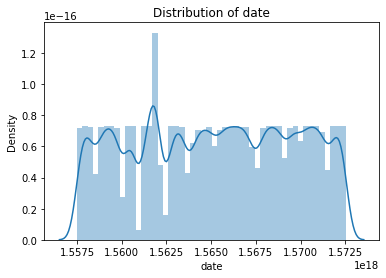

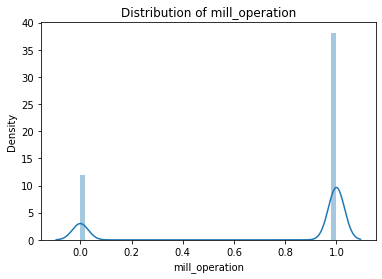

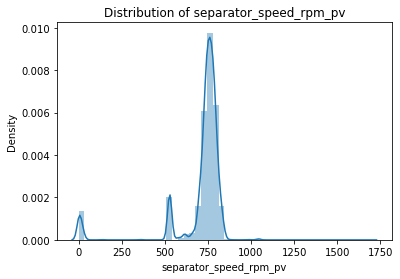

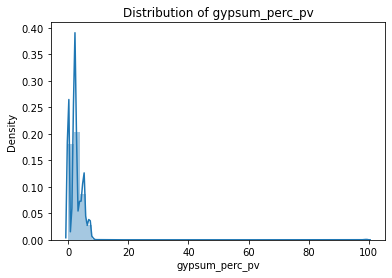

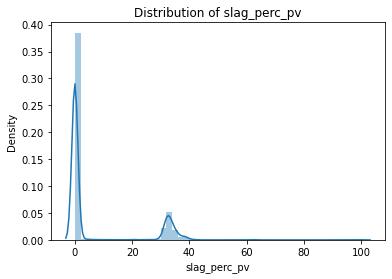

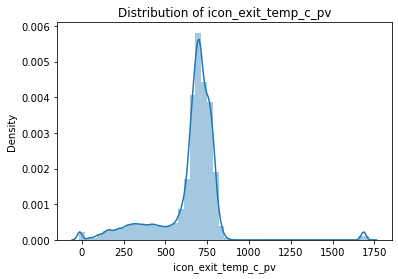

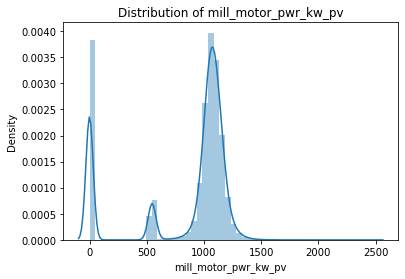

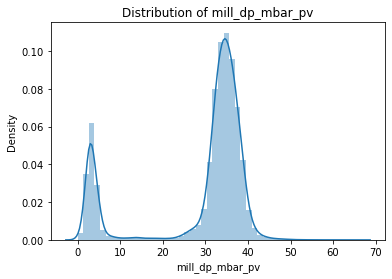

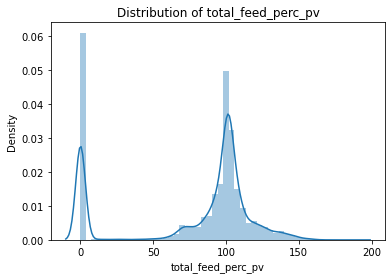

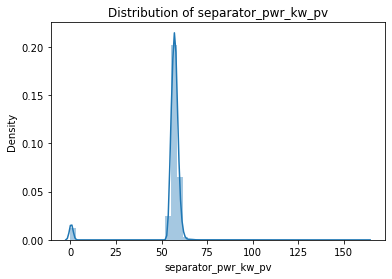

In [5]:
# Check distributions of column 1

for column in columns1:
   sns.distplot(all_months[column])
   plt.title(f'Distribution of {column}')
   plt.show()

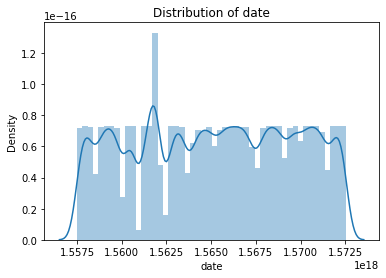

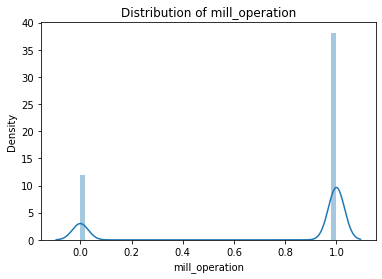

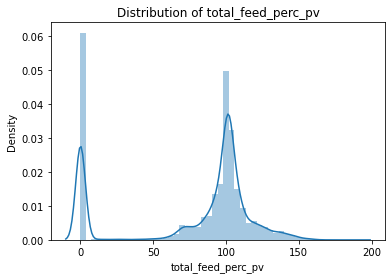

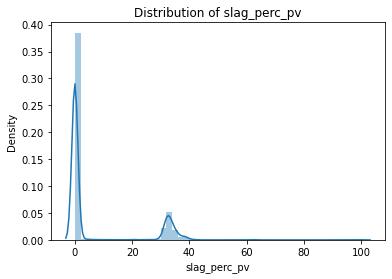

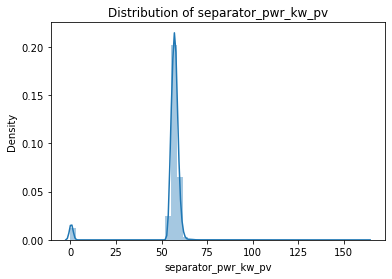

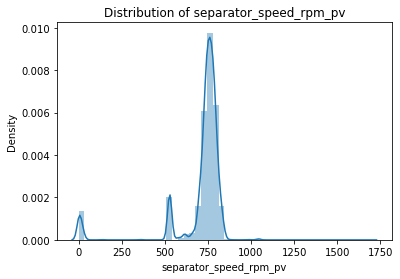

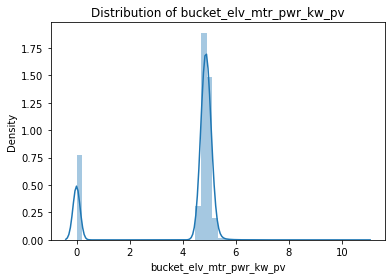

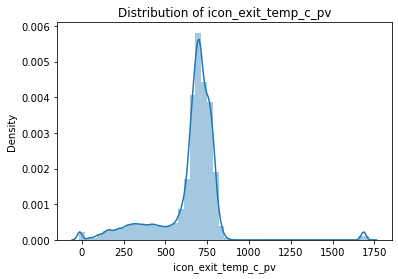

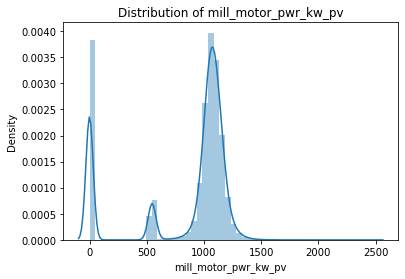

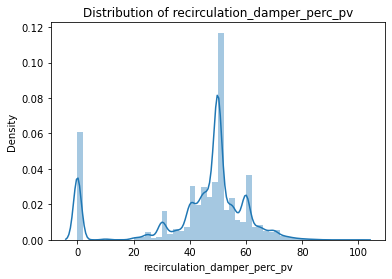

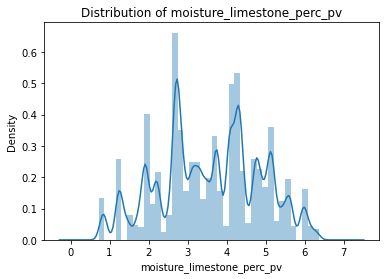

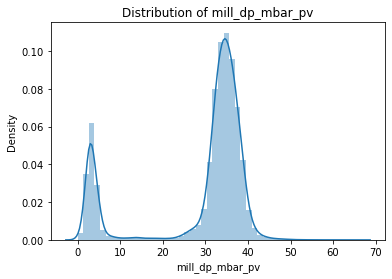

In [6]:
#Check the distributions of column 2

for column in columns2:
   sns.distplot(all_months[column])
   plt.title(f'Distribution of {column}')
   plt.show()

In [7]:
all_months_cleared = all_months[(all_months['total_feed_perc_pv'].astype(float)> 66) & (all_months['mill_operation'] == 1)]


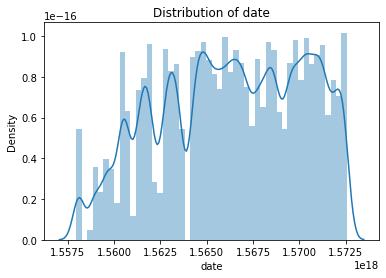

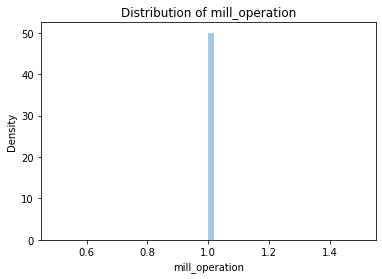

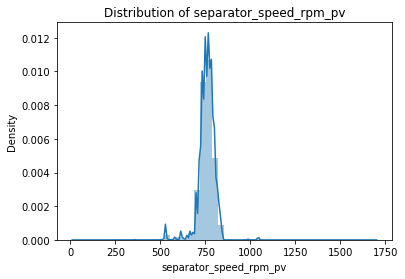

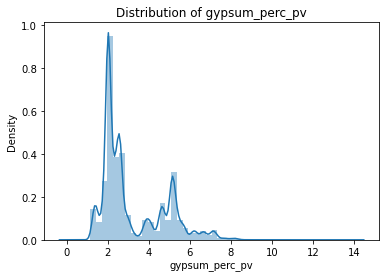

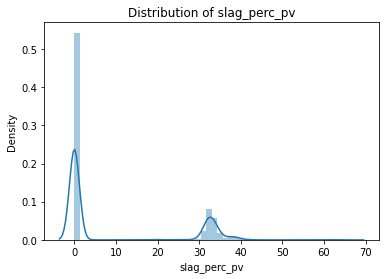

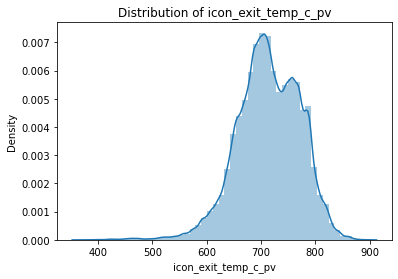

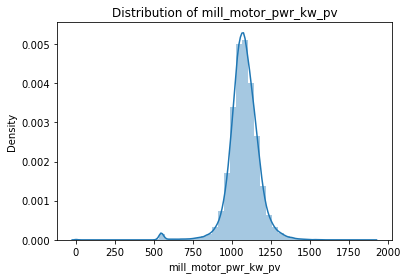

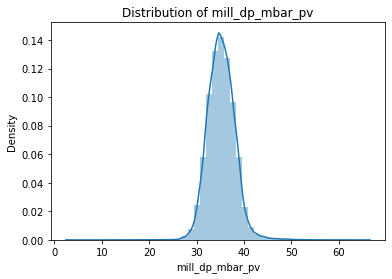

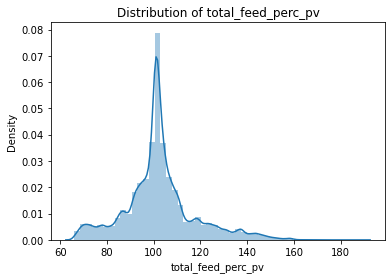

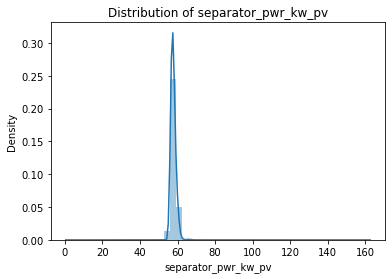

In [8]:
#Check distributions under normal working conditions for column 1

for column in columns1:
   sns.distplot(all_months_cleared [column])
   plt.title(f'Distribution of {column}')
   plt.show()

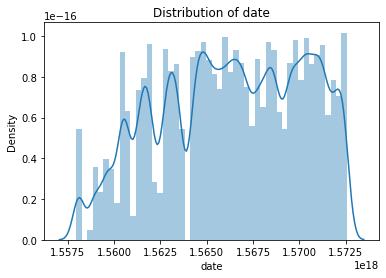

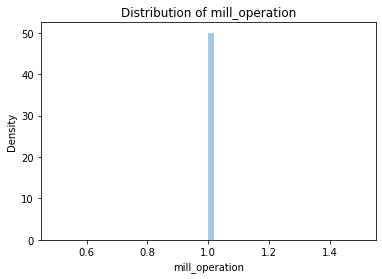

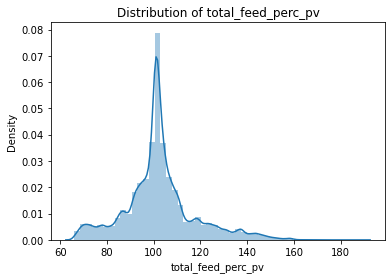

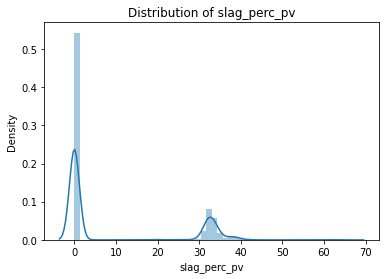

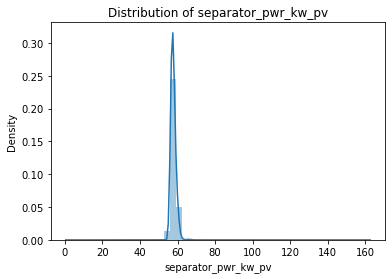

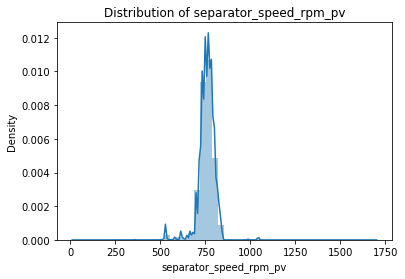

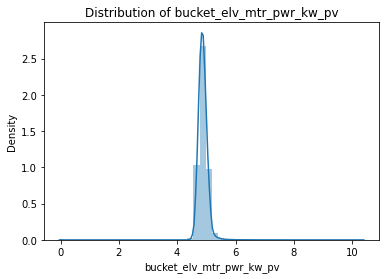

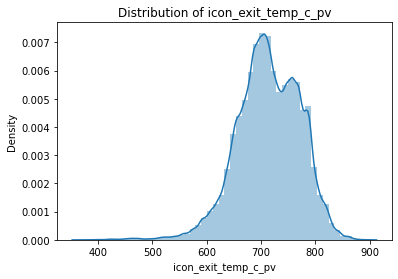

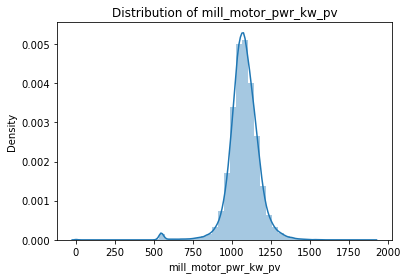

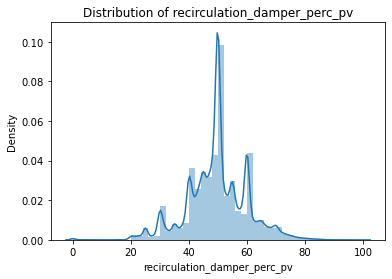

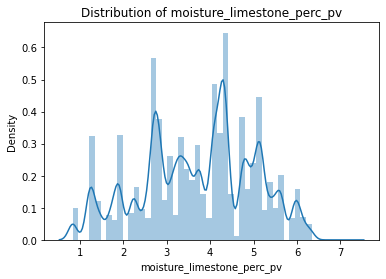

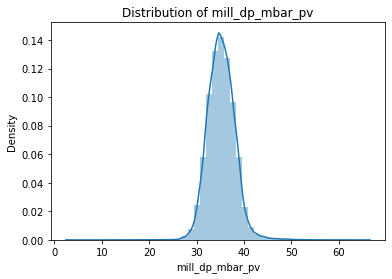

In [9]:
#Check distributions under normal working conditions for column 2

for column in columns2:
   sns.distplot(all_months_cleared [column])
   plt.title(f'Distribution of {column}')
   plt.show()

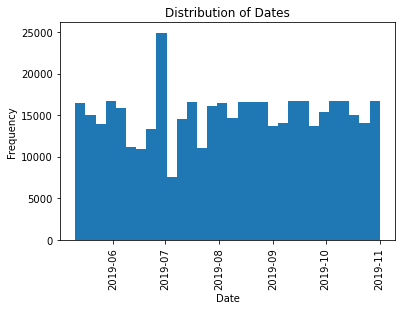

In [10]:
#Histogram for Date

plt.hist(all_months['date'], bins=30)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.show()

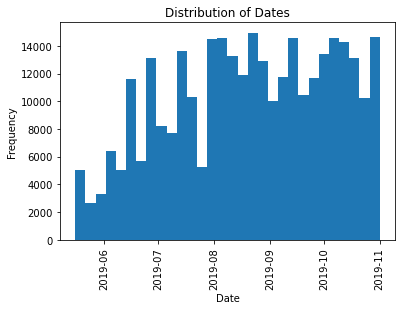

In [11]:
#Histogram for Date under normal working conditions

plt.hist(all_months_cleared['date'], bins=30)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.show()

Printing NaN's
mill_operation             22
separator_speed_rpm_pv     16
gypsum_perc_pv             25
slag_perc_pv               25
icon_exit_temp_c_pv       252
mill_motor_pwr_kw_pv       21
mill_dp_mbar_pv            19
total_feed_perc_pv        123
separator_pwr_kw_pv        21
dtype: int64


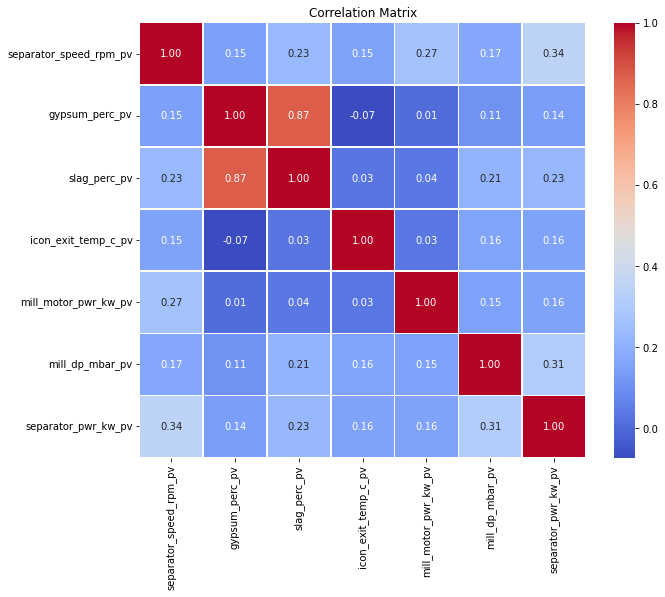

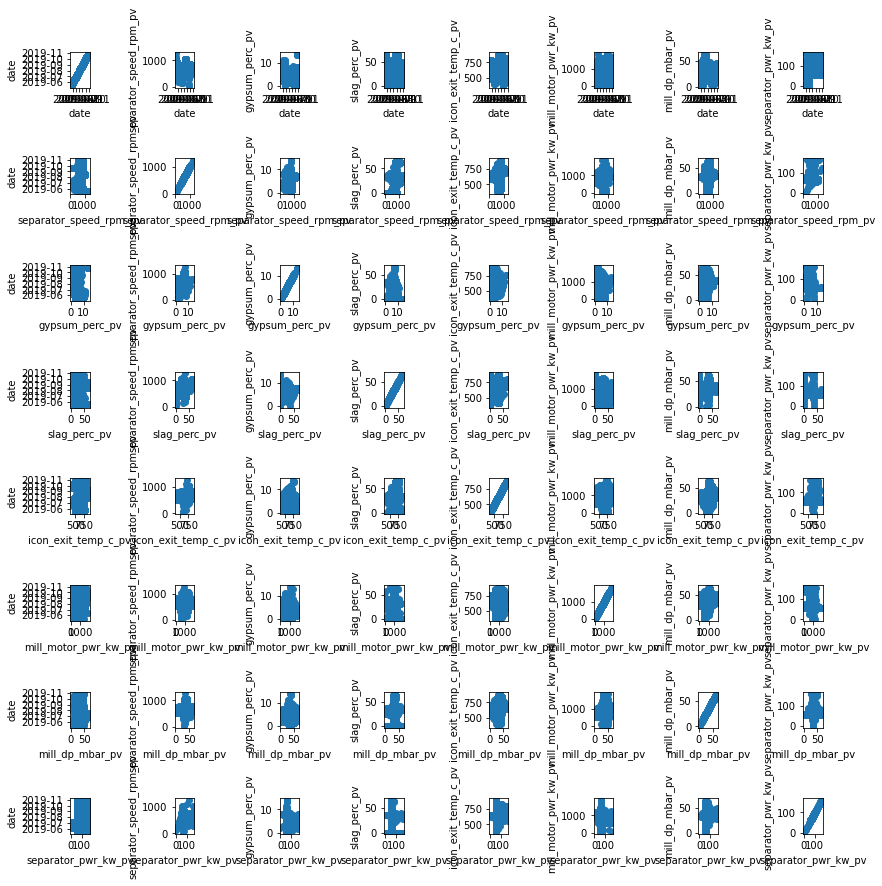

In [5]:
#To check the models for Block 2 change the comment from line 2 to line 1 

x_train,x_validation,x_test,y_train,y_validation,y_test,sc,dates = Preprocessing(all_months,columns1,True)
#x_train,x_validation,x_test,y_train,y_validation,y_test,sc,dates = Preprocessing(all_months,columns2,False)
dates_val = dates[1].values
dates_test = dates[2].values

In [6]:
lr, lr_val_pred , lr_test_pred = linearRegr(x_train,x_validation,x_test,y_train,y_validation,y_test)
lr_val_pred,lr_test_pred = PredictionsReverseNormalize(lr_val_pred,lr_test_pred,sc)

mean_squared_error:    0.03480172526237078
mean_absolute_error:    0.09234404825038707
mean_absolute_percentage_error:    0.8858930472047856
r2_score:    0.9513136029728807
mean_squared_error:    0.035797317174196146
mean_absolute_error:    0.0987611238640735
mean_absolute_percentage_error:    1.3380281673154701
r2_score:    0.9382559259920263


In [7]:
pls_model , pls_val_pred , pls_test_pred = plsRegr(x_train, x_validation, x_test, y_train, y_validation, y_test)
pls_val_pred,pls_test_pred = PredictionsReverseNormalize(pls_val_pred,pls_test_pred,sc)

mean_squared_error:    0.02963103997604488
mean_absolute_error:    0.08450125094487695
mean_absolute_percentage_error:    0.7704361222182854
r2_score:    0.9585483022461286
mean_squared_error:    0.02962281252912329
mean_absolute_error:    0.08686700312740864
mean_absolute_percentage_error:    0.9540478540744216
r2_score:    0.9489098294325589


In [8]:
# lasso_model, lasso_val_pred , lasso_test_pred = lassoRegr(x_train, x_validation, x_test, y_train, y_validation, y_test, alpha=0.01)
# lasso_val_pred,lasso_test_pred = PredictionsReverseNormalize(lasso_val_pred,lasso_test_pred,sc)

In [9]:
forest_model, forest_val_pred , forest_test_pred = forestRegr(x_train, x_validation, x_test, y_train, y_validation, y_test)
forest_val_pred,forest_test_pred = PredictionsReverseNormalize(forest_val_pred,forest_test_pred,sc)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  4.7min


building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  9.8min


building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed: 15.1min


building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 24.8min


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 34.6min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 41.1min


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed: 50.8min remaining:  3.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed: 51.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


mean_squared_error:    0.03350529013447205
mean_absolute_error:    0.08470781945408953
mean_absolute_percentage_error:    0.9209012091775104
r2_score:    0.9531275926611356


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  47 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    0.4s finished


mean_squared_error:    0.030906182473804954
mean_absolute_error:    0.08620962026228482
mean_absolute_percentage_error:    1.0360446861448778
r2_score:    0.9466889104155337


In [10]:
#END OF MODELS IF YOU WANT MORE, ABOVE HERE
y_train, y_validation, y_test = ReverseNormalize(y_train,y_validation,y_test,sc)

In [18]:
start = 2000
end = 2020

In [22]:
#LINEAR
title = 'LINEAR REGRESSION'
plotZoomedPrediction(y_validation,lr_val_pred,title,dates_val,start,end)

plotZoomedPrediction(y_test,lr_test_pred,title,dates_test,start,end)

In [26]:
#PLS
title = 'PLS REGRESSION'
plotZoomedPrediction(y_validation,pls_val_pred,title,dates_val,start,end)

plotZoomedPrediction(y_test,pls_test_pred,title,dates_test,start,end)

In [15]:
# # #LASSO
# title = 'LASSO REGRESSION'
# plotZoomedPrediction(y_validation,lasso_val_pred,title,dates_val,start,end)
# plotZoomedPrediction(y_test,lasso_test_pred,title,dates_test,start,end)

In [19]:
#FOREST
title = 'RANDOM FOREST REGRESSION '
plotZoomedPrediction(y_validation,forest_val_pred,title,dates_val,start,end)
plotZoomedPrediction(y_test,forest_test_pred,title,dates_test,start,end)
